In [1]:
import numpy as np
import gym
import random
from collections import namedtuple,deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)

[0]

In [3]:
print(env.observation_space)
print(env.action_space.n)

Box(8,)
4


In [4]:
#parameter
batch_size = 64
max_capacity = int(1e5)
gamma = .99
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
UPDATE_EVERY = 4
LR = 5e-4
TAU = 1e-3

In [5]:
class Agent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.local_net = QNetwork(state_size, action_size, seed).to(device)
        self.target_net = QNetwork(state_size, action_size, seed).to(device)
        self.memory = ReplayBuffer(batch_size, max_capacity, seed)
        self.optimizer = optim.Adam(self.local_net.parameters(),lr = LR)
        self.t_steps = 0
    
    def epsilon_greedy(self,action_values,eps):    
        random_gen = random.uniform(0,1)
        if random_gen > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def act(self, state, eps = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_net.eval()
        with torch.no_grad():
            action_values = self.local_net(state)
#             print('Action Values : ',action_values)
#             print('Action Values size : ',action_values.shape)
        self.local_net.train()
        return self.epsilon_greedy(action_values,eps)
    
    def step(self,state,action,reward,next_state,done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_steps = (self.t_steps + 1) % UPDATE_EVERY
        if self.t_steps  == 0:     
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences,gamma)
    
    def learn(self,experiences,gamma):
        
        states,actions,rewards,next_states,dones = experiences
        
        targeted_output_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        target_totals = rewards + (gamma*targeted_output_next*(1-dones))
        local_outputs = self.local_net(states).gather(1,actions)
        
        loss = F.mse_loss(local_outputs,target_totals)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        #updating target_net
        self.update(self.local_net,self.target_net,TAU)
    
    def update(self,local_model,target_model,tau):
        
        for local_param,target_param in zip(local_model.parameters(),target_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

In [6]:
class QNetwork(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units = 64,fc2_units = 64):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,action_size)
        
    def forward(self,state):
        output = F.relu(self.fc1(state))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [7]:
class ReplayBuffer:
    def __init__(self,batch_size,max_capacity,seed):
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.buffer_size = max_capacity
        self.buffer = deque(maxlen = max_capacity)
        self.experience = namedtuple('Experiences',field_names = ['state','action','reward','next_state','done'])
    
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.buffer.append(e)
    
    def sample(self):
        batch = random.sample(self.buffer,k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([b.state for b in batch if b is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([b.action for b in batch if b is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([b.reward for b in batch if b is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([b.next_state for b in batch if b is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([b.done for b in batch if b is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.buffer)

In [8]:
agent = Agent(state_size = 8, action_size = 4, seed = 0)

In [9]:
state = env.reset()
for j in range(200):
    print(state)
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

[-5.9156417e-04  1.4134574e+00 -5.9935719e-02  1.1277095e-01
  6.9228926e-04  1.3576316e-02  0.0000000e+00  0.0000000e+00]
[-1.1833191e-03  1.4154168e+00 -5.9854437e-02  8.7087154e-02
  1.3631723e-03  1.3419589e-02  0.0000000e+00  0.0000000e+00]
[-0.00177507  1.4167767  -0.05985659  0.06043859  0.00203362  0.0134106
  0.          0.        ]
[-0.00236692  1.4175365  -0.05985857  0.03376723  0.00270402  0.01340915
  0.          0.        ]
[-0.00295877  1.4176962  -0.05986055  0.00709888  0.00337431  0.01340707
  0.          0.        ]
[-0.00355053  1.4172561  -0.05986254 -0.01956945  0.00404449  0.01340497
  0.          0.        ]
[-0.00414238  1.4162157  -0.05986452 -0.04623773  0.00471456  0.01340287
  0.          0.        ]
[-0.00473423  1.4145753  -0.0598665  -0.07290607  0.00538452  0.01340077
  0.          0.        ]
[-0.00532618  1.4123349  -0.05986847 -0.09957445  0.0060544   0.01339866
  0.          0.        ]
[-0.00591812  1.4094945  -0.05987043 -0.12624289  0.00672416  

Episode : 100	 Average Reward : -176.47
Episode : 200	 Average Reward : -116.37
Episode : 300	 Average Reward : -52.67
Episode : 400	 Average Reward : -9.19
Episode : 500	 Average Reward : 92.68
Episode : 600	 Average Reward : 138.79
Episode : 700	 Average Reward : 186.01
Episode : 800	 Average Reward : 216.61
Episode : 900	 Average Reward : 238.65
Episode : 1000	 Average Reward : 220.20
Episode : 1100	 Average Reward : 225.34
Episode : 1200	 Average Reward : 236.66
Episode : 1300	 Average Reward : 231.03
Episode : 1400	 Average Reward : 239.17
Episode : 1500	 Average Reward : 239.12
Episode : 1600	 Average Reward : 244.53
Episode : 1606	 Average Score: 250.78
Environment solved in 1506 episodes!	Average Score: 250.78


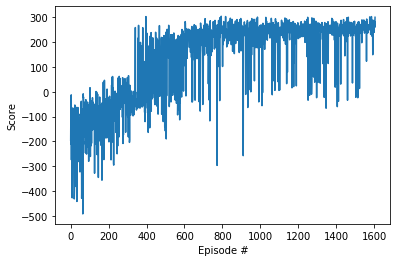

In [10]:
def DQN(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_min = .01, eps_decay = 0.995, window = 100):
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=window)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        eps = max(eps*eps_decay,eps_min)
        scores.append(score)
        print('\rEpisode : {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode%100 == 0:
            print('\rEpisode : {}\t Average Reward : {:.2f}'.format(i_episode,np.mean(scores_window)))
        if np.mean(scores_window)>=250.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.local_net.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = DQN()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
agent.local_net.load_state_dict(torch.load('checkpoint.pth'))
for i_episode in range(10):
    state = env.reset()
    rewards = 0
    for j in range(1000):
        action = agent.act(state)
        env.render()
        next_state,reward,done,_ = env.step(action)
        state = next_state
        rewards += reward
        if done:
            break
    print('\nReward per episode : {}'.format(rewards))

env.close()


Reward per episode : 250.204496651569

Reward per episode : 262.80010020612895

Reward per episode : 247.43516978062655

Reward per episode : 252.50346612237502

Reward per episode : 281.36777740611103

Reward per episode : 249.21128213542923

Reward per episode : 263.4675361436822

Reward per episode : 267.84744132624826

Reward per episode : 289.45279108565745

Reward per episode : 283.47072175201856
